In the previous section, we have seen stereo matching using traditional shallow features with different metrics. 
In this section, we will see how to train deep network for stereo matching problem. 

The basic idea is to train a deep network that can perform patch matching. To train the network, we will use KITTI 2015 dataset available at http://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo.

The dataset provides a pair of stero-images with ground-truth disparity between the images. Using this dataset, 
we will create pairs of (left, right, disparity) data and then train a network that predicts the disparity given a pair of images.

This tutorial is primarily based on "Wenjie Luo et al. Efficient Deep Learning for Stereo Matching". Interested readers can refer the above paper for more details.

In [47]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from os.path import join

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
root  = 'data'

Using cuda device


Let's look into some of the KITTI images.

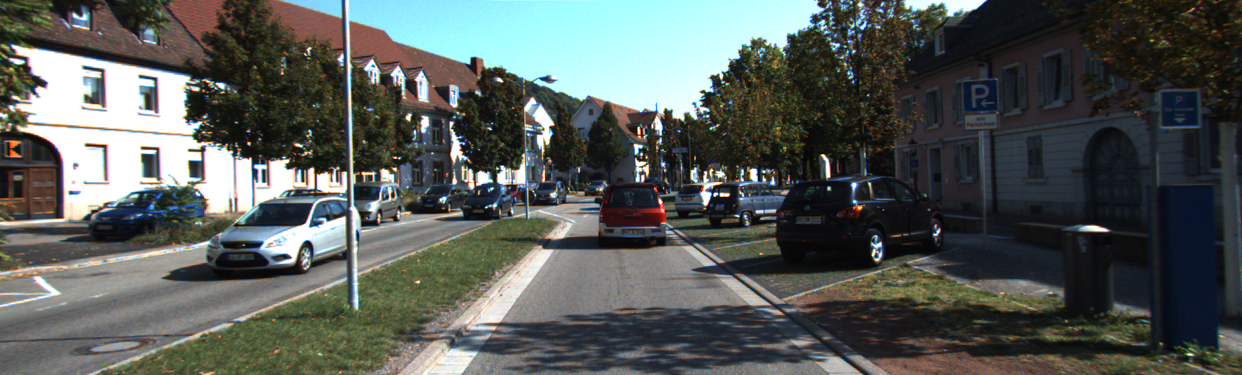

In [24]:
Image.open(join(root, '000123_11_L.png'))


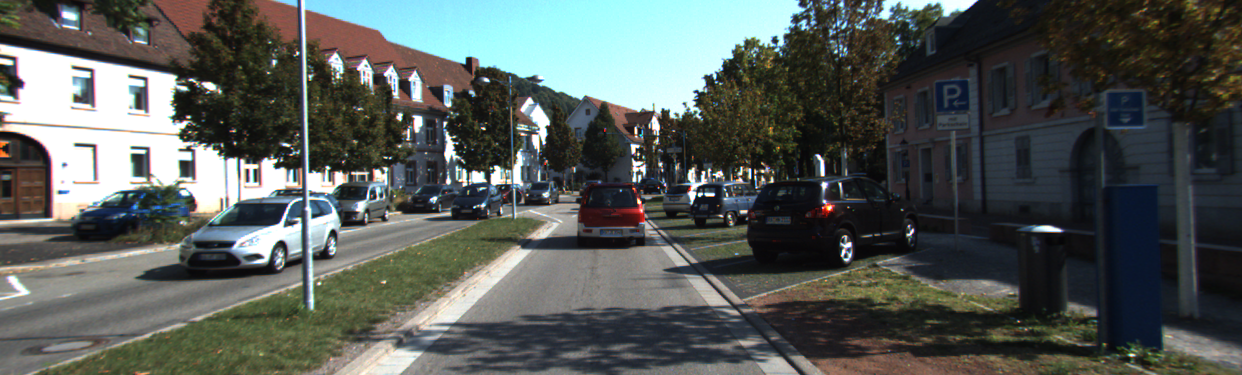

In [25]:
Image.open(join(root, '000123_11_R.png'))


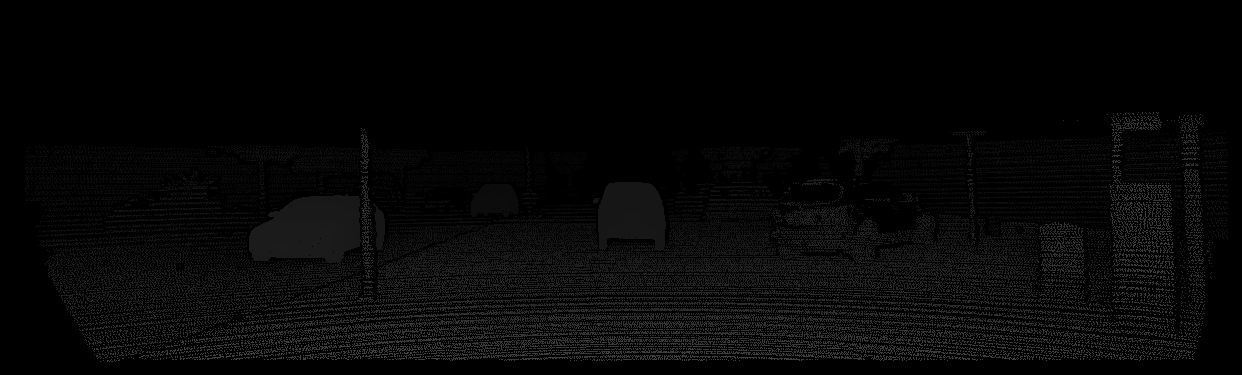

In [26]:
Image.open(join(root, '000123_disp.png'))

### Patch Extraction:

We need to extract patches from these left and right images, and train a network with a known disparity between them.

We extract patches of size 37x37 from left images. From the corresponding right images, we extract larger patches of size 37x237, centered around disparity location given in the disparity map.

For e.g. if the left patch in the left image is centered at (x1,y1) has a dimension of 37x37. Let's assume the ground truth disparity at (x1,y1) in disparity map is "d".  We then extract a right patch centered at (x1+d, y1) in the right image with a dimension of 37x237.

Lets look into some of the left and right patches.

In [39]:
left_patches = torch.tensor(np.load(join(root, 'left_patches.npy')))
right_patches = torch.tensor(np.load(join(root, 'right_patches.npy')))
targets = torch.tensor(np.load(join(root, 'targets.npy')))


In [41]:
print(left_patches.size())
print(right_patches.size())
print(targets.size())

torch.Size([19200, 3, 37, 37])
torch.Size([19200, 3, 37, 237])
torch.Size([19200, 1])


Lets display some of these images.. You may notice some artifacts as we normalized the patches with mean and standard deviation of the images. 

The disparity value specifies the position at which left patch is occuring in the larger right patch

Left patch..


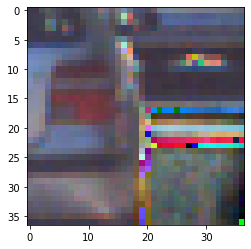

right patch..


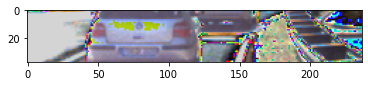

In [52]:
print('Left patch..')
plt.imshow(transforms.ToPILImage()(left_patches[2000]))
plt.show()
print('right patch..')
plt.imshow(transforms.ToPILImage()(right_patches[2000]))



## Network training

Let's create a deep network with 9 conv-batchnorm-relu layers. We use filters of constant size 5x5. Our architecture is a siamese network with shared weights between them.
<img src="temp/siamese.png",width=400,height=200>
We basically pass smaller left and larger right patches through the network and obtain the 64-dimensional deep features. The similarities are then computed using deep features to obtain the similarity score across multiple locations in the larger patch. The network is then optimized such that larger correlation is obtained at location given by the disparity (displacement) value.

In [53]:
class Net(nn.Module):    
    def __init__(self, nChannel, max_dips):
        super(Net, self).__init__()                        
        self.l_max_dips = max_dips
        self.conv1 = nn.Conv2d(nChannel, 32, 5)    # first conv layer: 32 filters of size 5x5
        self.batchnorm1 = nn.BatchNorm2d(32, 1e-3) # first batch normalization layer
        
        self.conv2 = nn.Conv2d(32, 32, 5)          # second conv layer: 32 filters of size 5x5
        self.batchnorm2 = nn.BatchNorm2d(32, 1e-3) # second normalization layer
        
        self.conv3 = nn.Conv2d(32, 64, 5)          # third conv layer: 64 filters of size 5x5
        self.batchnorm3 = nn.BatchNorm2d(64, 1e-3) # third batch normalization layer
        
        self.conv4 = nn.Conv2d(64, 64, 5)          # fourth conv layer: 64 filters of size 5x5
        self.batchnorm4 = nn.BatchNorm2d(64, 1e-3) # fourth batch normalization layer
        
        self.conv5 = nn.Conv2d(64, 64, 5)          # fifth conv layer: 64 filters of size 5x5
        self.batchnorm5 = nn.BatchNorm2d(64, 1e-3) # fifth batch normalization layer
        
        self.conv6 = nn.Conv2d(64, 64, 5)          # sixth conv layer: 64 filters of size 5x5
        self.batchnorm6 = nn.BatchNorm2d(64, 1e-3) # sixth batch normalization layer
        
        self.conv7 = nn.Conv2d(64, 64, 5)          # seventh conv layer: 64 filters of size 5x5
        self.batchnorm7 = nn.BatchNorm2d(64, 1e-3) # seventh batch normalization layer
        
        self.conv8 = nn.Conv2d(64, 64, 5)          # eighth conv layer: 64 filters of size 5x5
        self.batchnorm8 = nn.BatchNorm2d(64, 1e-3) # eigth batch normalization layer        
            
        self.conv9 = nn.Conv2d(64, 64, 5)          # ninth conv layer: 64 filters of size 5x5
        self.batchnorm9 = nn.BatchNorm2d(64, 1e-3) # ninth batch normalization layer        
        self.logsoftmax = nn.LogSoftmax()                        
            
    def forward_pass(self, x):
        x = self.conv1(x)                
        x = F.relu(self.batchnorm1(x))
        
        x = self.conv2(x)
        x = F.relu(self.batchnorm2(x))
        
        x = self.conv3(x)
        x = F.relu(self.batchnorm3(x))
        
        x = self.conv4(x)
        x = F.relu(self.batchnorm4(x))
        
        x = self.conv5(x)
        x = F.relu(self.batchnorm5(x))
        
        x = self.conv6(x)
        x = F.relu(self.batchnorm6(x))
        
        x = self.conv7(x)
        x = F.relu(self.batchnorm7(x))
        
        x = self.conv8(x)
        x = F.relu(self.batchnorm8(x))
        
        x = self.conv9(x)
        x = self.batchnorm9(x)
        return x
             
    def forward(self, x1, x2):
        # forward pass left patch of 37x37
        x1 = self.forward_pass(x1)
        # forward pass right patch of 37*237
        x2 = self.forward_pass(x2)
        
        # left patch feature vector (1,64) dimension
        x1 = x1.view(x1.size(0),1,64)        
        
        # right patch feature matrix (64, 201) dimension
        # at 201 locations        
        x2 = x2.squeeze().view(x2.size(0),64,self.l_max_dips)
        
        # multiply the features to get correlation at 201 location
        x3 = x1.bmm(x2).view(x2.size(0),self.l_max_dips)
        
        # compute log p_i(y_i) of scores
        x3 = self.logsoftmax(x3)
        
        return x1,x2,x3  

Training parameters

In [54]:
# maxmium number of epochs to train the model
max_epoch = 5

# number of iterations in each epoch
iter_per_epoch = 50

# number of samples in each iteration
batchSize = 64

# gpu option. set 1 if available, else 0
gpu = 1

# learning rate used for Adam optimizer
learn_rate = 0.01

# momentum parameter for Adam
momentum = 0.9

# weight decay
weightDecay = 0.0005

# left patch is searched for 2*half_range + 1 locations
#in the right patch.

# If left patch is 37*37, and we consider 
# right patch of size 37 * (37+2*half_range)
half_range = 100

## Custom Loss function      

We minimize cross-entropy loss with respect to the weights w that parameterize the network

<img src="temp/eq.png",width=300,height=70>
where the class weights are given as
<img src="temp/eq2.png",width=300,height=60>

This basically implies that scores at desired location (given by disparity target ground truth) should be larger compared to other locations. To handle noise, two similarity scores on either side of disparity location are considered, however with smaller weightage given to them.

In [55]:
# three pixel error
def loss_function(x3, t, w):    
    error = 0
    for i in range(x3.size(0)):          
        # scores at ground truth target locations.
        # instead of taking single score at exact target disparity
        # location two more locations on either side are considered
        # with less weightage.
        sc = x3[i,t[i][0]-2:t[i][0]+2+1] 
        
         #class_weight_y_i* log p_i(y_i)
        loss_sample = torch.mul(sc, w).sum()        
        
        error = error - loss_sample
        
    return error

We define the class weights as follows:

In [56]:
class_wts = torch.Tensor([1, 4, 10, 4, 1])

In [57]:
# instantiate a model
model = Net(3, half_range*2+1)
if gpu:
    model = model.to(device)
    class_wts = class_wts.to(device)
model.train() # train mode.

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm5): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm6): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(64, 64, kernel_size=(5, 5), stride=(

We use Adam optimizer for training the network

In [58]:
optimizer = optim.Adam(model.parameters(), lr=learn_rate, eps=1e-08, weight_decay=weightDecay)

Let's train

In [61]:
for epoch in range(max_epoch):
    train_loss = 0    
    for _iter in range(iter_per_epoch):        
        
        # zero the gradient buffers
        optimizer.zero_grad()   
        
        # sample batch data
        id1 = epoch*iter_per_epoch*batchSize +  _iter*batchSize
        id2 = epoch*iter_per_epoch*batchSize + (_iter+1)*batchSize        
        left_batch = left_patches[id1:id2, :, :, :]
        right_batch = right_patches[id1:id2, :, :, :]
        t_batch = targets[id1:id2].view(batchSize,1).int()
        
        # convert to cuda if gpu available
        if gpu:
            left_batch = left_batch.to(device)
            right_batch = right_batch.to(device)
            t_batch = t_batch.to(device)
         
        # forward pass
        x1, x2, x3 = model(left_batch, right_batch)
        
        # compute loss
        loss = loss_function(x3, t_batch, class_wts)
        
        # backward pass. compute gradients
        loss.backward()
        
        # update the weights
        optimizer.step()
        
        train_loss+=loss.item()
        
    print('Loss at epoch ', epoch, train_loss/iter_per_epoch)

<ipython-input-53-d2c2bd8333df>:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x3 = self.logsoftmax(x3)


Loss at epoch  0 12566.090439453124
Loss at epoch  1 6586.002197265625
Loss at epoch  2 6057.208271484375
Loss at epoch  3 5910.969384765625
Loss at epoch  4 5730.4779296875
